# Assignment1: PyTorch Classification
* Cifar10 dataset에 대해 정확도 97% 이상의 Classifier를 만드세요
* 코드 수정 가능 (단, 첫 번째 cell은 건드리지 말 것)
* Hint. 모델 디자인 뿐만 아니라 transfer learning, batch size 및 learning rates 조절, data augmentation 등을 통해 분류기 정확도를 높일 수 있음. (https://pytorch.org/vision/stable/transforms.html)
* 단, transfer learning 사용 시, cifar10에 학습된 모델을 사용하는 것은 금지함.

## 아래 코드는 Shallow CNN을 사용한 예시 코드입니다.
* 바로 아래 위치한 셀은 수정하시면 안됩니다.

In [49]:
import cv2
import copy
from matplotlib import pyplot as plt
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import numpy as np

# Do not touch codes below!
# These codes control random seed for reproduction
seed = 7777

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [50]:
!pwd

/home/piai/dongho


#### Dataset CIFAR10 download

In [51]:
img_dir = './CIFAR10'


cifar10_train = datasets.CIFAR10(
    img_dir, download=True, transform = ToTensor(), train=True)

cifar10_test = datasets.CIFAR10(
    img_dir, download=True, transform = ToTensor(), train=False)

dataloader_train = DataLoader(cifar10_train,
                              batch_size=128,
                              shuffle=True)

dataloader_test = DataLoader(cifar10_test,
                              batch_size=128,
                              shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


#### Check images

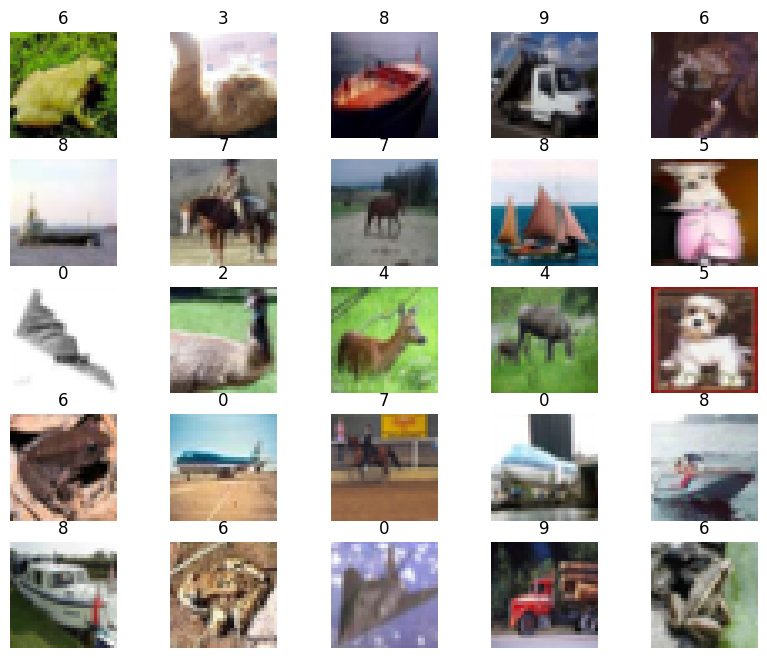

torch.Size([3, 32, 32])


In [52]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cifar10_train), size=(1,)).item()
    img, label = cifar10_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0).squeeze(), cmap="gray")
plt.show()
print(img.shape)

#### Basic model using CNN
##### structure
- Convolution 1 : channels 16, kernel size 5, stride 1, padding 2 (output resolution?)
- ReLU
- MaxPool : kernel_size 2, stride 2
- Convlution 2 : channels 32, kernel size 5, stride 1, padding 2 (output resolution?)
- Linear : output channels 10 

##### This model below is just for an example

##### https://pytorch.org/docs/1.12/nn.html

In [53]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 8 * 8, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

#### Train

In [54]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cnn = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)

In [55]:
# Train the model
num_epochs = 10

model_best = None
acc_best = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0

    cnn.train()
    for i, (images, labels) in enumerate(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        output = cnn(images)
        _, preds = torch.max(output, 1)
        loss = loss_func(output, labels)

        # clear gradients for this training step
        optimizer.zero_grad()

        # backpropagation, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(cifar10_train)
    epoch_acc = running_corrects.double() / len(cifar10_train)
    print ('Epoch [{}/{}], Train -> Loss: {:.4f}, Acc: {:.4f}'
                   .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))


    running_loss = 0.0
    running_corrects = 0
    cnn.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader_test):
            images = images.to(device)
            labels = labels.to(device)

            # Inference
            output = cnn(images)
            _, preds = torch.max(output, 1)

            # Calculate loss
            loss = loss_func(output, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # 통계값
    epoch_loss = running_loss / len(cifar10_test)
    epoch_acc = running_corrects.double() / len(cifar10_test)

    print ('Epoch [{}/{}], Valid -> Loss: {:.4f}, Acc: {:.4f}'
               .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))

    # Fine the best model
    if acc_best < epoch_acc:
        acc_best = epoch_acc
        model_best = copy.deepcopy(cnn)

Epoch [1/10], Train -> Loss: 1.8088, Acc: 0.3492
Epoch [1/10], Valid -> Loss: 1.5074, Acc: 0.4574
Epoch [2/10], Train -> Loss: 1.3944, Acc: 0.5026
Epoch [2/10], Valid -> Loss: 1.2730, Acc: 0.5412
Epoch [3/10], Train -> Loss: 1.2255, Acc: 0.5680
Epoch [3/10], Valid -> Loss: 1.1939, Acc: 0.5772
Epoch [4/10], Train -> Loss: 1.1211, Acc: 0.6113
Epoch [4/10], Valid -> Loss: 1.0947, Acc: 0.6220
Epoch [5/10], Train -> Loss: 1.0339, Acc: 0.6422
Epoch [5/10], Valid -> Loss: 1.0355, Acc: 0.6364
Epoch [6/10], Train -> Loss: 0.9753, Acc: 0.6604
Epoch [6/10], Valid -> Loss: 1.0398, Acc: 0.6400
Epoch [7/10], Train -> Loss: 0.9290, Acc: 0.6792
Epoch [7/10], Valid -> Loss: 1.0002, Acc: 0.6546
Epoch [8/10], Train -> Loss: 0.8943, Acc: 0.6921
Epoch [8/10], Valid -> Loss: 1.0057, Acc: 0.6572
Epoch [9/10], Train -> Loss: 0.8643, Acc: 0.7014
Epoch [9/10], Valid -> Loss: 1.0056, Acc: 0.6601
Epoch [10/10], Train -> Loss: 0.8336, Acc: 0.7111
Epoch [10/10], Valid -> Loss: 0.9910, Acc: 0.6576


#### Test

In [ ]:
model_best.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)

        # Inference
        test_output = model_best(images)

        # Calculate error
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0)
    accuracy = correct / total * 100

print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 66.01 Percent


#### Save the model checkpoint

In [ ]:
torch.save(model_best.state_dict(), 'trained_model.pkl')

#### Load the trained model and test

In [ ]:
model_load = CNN().to(device)
model_load.load_state_dict(torch.load('trained_model.pkl'))

model_load.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)

        # Inference
        test_output = model_load(images)

        # Calculate error
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0)
    accuracy = correct / total * 100

print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 66.01 Percent


# Try your own codes!
* 과제로 제출한 checkpoint를 'torch.load' 및 'torch.load_state_dict'를 사용해 불러온 후, accuracy를 측정할 예정입니다.
* 위의 Save 및 Load 코드를 기반으로 여러분이 직접 학습한 모델의 checkpoint가 잘 동작하는지 확인하시기 바랍니다.

In [22]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in /home/piai/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /home/piai/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:10<00:00, 112MB/s] 


In [23]:
!pip install --extra-index-url https://download.pytorch.org/whl/cu117 torch==2.0.0
!pip install --extra-index-url https://download.pytorch.org/whl/cu117 torchvision==0.15.0

!pip install omegaconf
!pip install torchmetrics==0.10.3
!pip install fvcore
!pip install iopath
!pip install submitit

!pip install xformers==0.0.18

!pip install --extra-index-url https://pypi.nvidia.com cuml-cu11

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [40]:
import cv2
import copy
from matplotlib import pyplot as plt
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import numpy as np

# Do not touch codes below!
# These codes control random seed for reproduction
seed = 7777

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [59]:
img_dir = './CIFAR10'

transform_train = transforms.Compose([transforms.Resize((42,42)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])


transform = transforms.Compose([transforms.Resize((42,42)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root=img_dir, train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root=img_dir, train=False, download=True, transform=transform)
 
dataloader_train = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
dataloader_test = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [42]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = copy.deepcopy(dinov2_vitl14)
        self.classifier = nn.Sequential(nn.Linear(1024, 256), nn.ReLU(), nn.Linear(256, 10))

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x


model_dino = DinoVisionTransformerClassifier()

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model_dino = model_dino.to(device)
model_dino = model_dino.train()

Device:  cuda:0


In [44]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_dino.parameters(), lr=1e-6)

In [45]:
num_epochs = 50

In [46]:
# Train the model

model_best = None
acc_best = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0

    model_dino.train()
    for i, (images, labels) in enumerate(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        output = model_dino(images)
        _, preds = torch.max(output, 1)
        loss = loss_func(output, labels)

        # clear gradients for this training step
        optimizer.zero_grad()

        # backpropagation, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(cifar10_train)
    epoch_acc = running_corrects.double() / len(cifar10_train)
    print ('Epoch [{}/{}], Train -> Loss: {:.4f}, Acc: {:.4f}'
                   .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))
    running_loss = 0.0
    running_corrects = 0
    model_dino.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader_test):
            images = images.to(device)
            labels = labels.to(device)
            # Inference
            output = model_dino(images)
            _, preds = torch.max(output, 1)

            # Calculate loss
            loss = loss_func(output, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # 통계값
    epoch_loss = running_loss / len(cifar10_test)
    epoch_acc = running_corrects.double() / len(cifar10_test)

    print ('Epoch [{}/{}], Valid -> Loss: {:.4f}, Acc: {:.4f}'
               .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))

    # Fine the best model
    if acc_best < epoch_acc:
        acc_best = epoch_acc
        model_best_dino = copy.deepcopy(model_dino)

/home/piai/anaconda3/envs/dongho/lib/python3.10/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/home/piai/anaconda3/envs/dongho/lib/python3.10/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


Epoch [1/50], Train -> Loss: 1.5073, Acc: 0.4857
Epoch [1/50], Valid -> Loss: 0.8066, Acc: 0.7526
Epoch [2/50], Train -> Loss: 0.6423, Acc: 0.7861
Epoch [2/50], Valid -> Loss: 0.3518, Acc: 0.8962
Epoch [3/50], Train -> Loss: 0.3922, Acc: 0.8709
Epoch [3/50], Valid -> Loss: 0.2192, Acc: 0.9349
Epoch [4/50], Train -> Loss: 0.2859, Acc: 0.9055
Epoch [4/50], Valid -> Loss: 0.1703, Acc: 0.9485
Epoch [5/50], Train -> Loss: 0.2350, Acc: 0.9224
Epoch [5/50], Valid -> Loss: 0.1395, Acc: 0.9562
Epoch [6/50], Train -> Loss: 0.1984, Acc: 0.9336
Epoch [6/50], Valid -> Loss: 0.1295, Acc: 0.9594
Epoch [7/50], Train -> Loss: 0.1706, Acc: 0.9432
Epoch [7/50], Valid -> Loss: 0.1213, Acc: 0.9613
Epoch [8/50], Train -> Loss: 0.1516, Acc: 0.9510
Epoch [8/50], Valid -> Loss: 0.1032, Acc: 0.9662
Epoch [9/50], Train -> Loss: 0.1374, Acc: 0.9545
Epoch [9/50], Valid -> Loss: 0.1015, Acc: 0.9665
Epoch [10/50], Train -> Loss: 0.1207, Acc: 0.9596
Epoch [10/50], Valid -> Loss: 0.0998, Acc: 0.9670
Epoch [11/50], Tra

In [60]:
model_best_dino.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)

        # Inference
        test_output = model_best_dino(images)

        # Calculate error
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0)
    accuracy = correct / total * 100

print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 97.70 Percent


In [48]:
torch.save(model_best_dino.state_dict(), '김동호_trained_model_dinov2.pkl')